# Stress Prediction using ANN

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [16]:
path = '../../../data/03_primary/WESAD_preprocessed_int15_add15/combined_subjects.csv'
data = pd.read_csv(path, index_col=0)
data.head()

,net_acc_mean,net_acc_std,net_acc_min,net_acc_max,EDA_phasic_mean,EDA_phasic_std,EDA_phasic_min,EDA_phasic_max,EDA_smna_mean,EDA_smna_std,EDA_smna_min,EDA_smna_max,EDA_tonic_mean,EDA_tonic_std,EDA_tonic_min,EDA_tonic_max,BVP_mean,BVP_std,BVP_min,BVP_max,TEMP_mean,TEMP_std,TEMP_min,TEMP_max,ACC_x_mean,ACC_x_std,ACC_x_min,ACC_x_max,ACC_y_mean,ACC_y_std,ACC_y_min,ACC_y_max,ACC_z_mean,ACC_z_std,ACC_z_min,ACC_z_max,0_mean,0_std,0_min,0_max,BVP_peak_freq,TEMP_slope,subject,label
0,1.331891,0.153556,1.014138,1.678399,2.247876,1.112076,0.367977,4.459367,1.592308,2.645333,3.096902e-08,17.418821,0.608263,1.212010,-1.213173,2.554750,-0.043934,112.391233,-392.28,554.77,35.816000,0.017436,35.77,35.87,0.024658,0.018284,-0.037843,0.087383,0.000017,0.000013,-0.000026,0.000060,0.000017,0.000013,-0.000026,0.000060,0.027558,0.013523,0.000000,0.087383,0.080556,-0.000102,2,1
1,1.218994,0.090108,1.014138,1.485800,1.781323,1.203991,0.232625,4.459367,1.347750,2.666659,3.096902e-08,17.418821,0.731985,1.171627,-1.213173,2.477276,-1.189267,120.431399,-392.28,554.77,35.796111,0.029522,35.75,35.87,0.020313,0.019242,-0.037843,0.087383,0.000014,0.000013,-0.000026,0.000060,0.000014,0.000013,-0.000026,0.000060,0.023420,0.015310,0.000000,0.087383,0.144444,-0.000424,2,1
2,1.143312,0.110987,0.948835,1.485800,1.173169,1.285422,0.006950,4.459367,0.752335,1.958546,3.096902e-08,17.418821,1.110242,1.112268,-1.213173,2.037179,0.280427,87.571000,-357.53,371.12,35.763056,0.044673,35.68,35.87,0.016618,0.015316,-0.021330,0.071558,0.000011,0.000011,-0.000015,0.000049,0.000011,0.000011,-0.000015,0.000049,0.018759,0.012604,0.000000,0.071558,0.102778,-0.000814,2,1
3,1.020669,0.135308,0.811090,1.239944,0.311656,0.278650,0.006950,1.303071,0.198576,0.413802,3.309991e-08,2.788862,1.598995,0.350355,0.959752,2.037179,0.055833,68.797466,-345.19,359.57,35.725000,0.033491,35.66,35.81,0.022681,0.012560,-0.006881,0.054356,0.000016,0.000009,-0.000005,0.000037,0.000016,0.000009,-0.000005,0.000037,0.022888,0.012180,0.000688,0.054356,0.108333,-0.000524,2,1
4,0.887458,0.116048,0.727406,1.125306,0.163826,0.110277,0.006950,0.369298,0.118080,0.237575,2.787285e-08,1.300810,1.342085,0.405980,0.945946,2.037179,0.096681,43.606312,-289.26,209.89,35.701333,0.022420,35.66,35.75,0.028105,0.010415,0.002752,0.054356,0.000019,0.000007,0.000002,0.000037,0.000019,0.000007,0.000002,0.000037,0.028105,0.010415,0.002752,0.054356,0.147222,-0.000165,2,1


In [17]:
pd.set_option('display.max_rows', 10)

### Data Preparation

#### Merged amusement
First we will merge the amusement data with the baseline data as after the EDA we found out that they are very simmilar.

In [18]:
data_merged_am = data.copy()
data_merged_am["label"] = data_merged_am["label"].replace([0], 1)
data_merged_am["label"].unique()

array([1, 2], dtype=int64)

Now we will split the data into train, validation and test sets.

In [19]:
features = ["EDA_smna_mean", "EDA_phasic_min", "EDA_tonic_mean", "EDA_tonic_min", "EDA_tonic_max"]
X = data_merged_am[features]
y = data_merged_am["label"]

X_train, X_test, y_train_merged_am, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training (1337 samples) and 20% test (334 samples)
X_val, X_test, y_val_merged_am, y_test_merged_am = train_test_split(X_test, y_test, test_size=0.1, random_state=42) # 90% of test set is used for validation (301 samples) and 10% for testing (33 samples)

We also need to scale the data so it lies between 0 and 1. This is important because the NN algorithm works better with scaled data, as generally activation function use values between 0 and 1.

In [20]:
scaler = MinMaxScaler()
X_train_merged_am = scaler.fit_transform(X_train)
X_val_merged_am = scaler.transform(X_val)
X_test_merged_am = scaler.transform(X_test)

#### Dropped amusement
First we will drop the amusement data to see if merging it with baseline confuses the algorithm.

In [21]:
data_no_am = data.copy()
data_no_am = data_no_am[data_no_am["label"] != 0]
data_merged_am["label"].unique()

array([1, 2], dtype=int64)

Now we will again split the data into train, validation and test sets and scale it.

In [22]:
X = data_no_am[features]
y = data_no_am["label"]

X_train, X_test, y_train_no_am, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test
X_val, X_test, y_val_no_am, y_test_no_am = train_test_split(X_test, y_test, test_size=0.1, random_state=42) # 90% of test set is used for validationand 10% for testing

scaler = MinMaxScaler()
X_train_no_am = scaler.fit_transform(X_train)
X_val_no_am = scaler.transform(X_val)
X_test_no_am = scaler.transform(X_test)

### Modeling and Training

We will create a function that will create, compile and train a model so we can easily try different models and compare them. We will use the Sequential model from Keras, which is a linear stack of layers. We will add the Dense layers, which are just regular densely connected NN layers. The last layer will have 3 neurons (the number of labels) by default. We will use the relu activation function for the hidden layers and the softmax activation function for the last one. The softmax function is used for multiclass classification problems, it returns the probability of each class.

In [23]:
def build_model(neurons_per_layer=[64, 64], n_outputs=3):
    model = Sequential()

    for i in range(len(neurons_per_layer)):
            model.add(Dense(neurons_per_layer[i], activation='relu'))

    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#### Merged amusement
In order to decide for how many epochs we will train the model, we will devide the lenght of the dataset by the batch size and multiply it by two. This will give us a good estimate of how many epochs we need to train the model.

In [24]:
batch_size = 32
len(y_train_merged_am) / batch_size * 2

104.5

The first model we will create will behave two layers with 64 neurons each. We will train for 20 epochs and use a standard batch size of 32.

In [25]:
model1 = build_model()
history1 = model1.fit(x=X_train_merged_am, y=y_train_merged_am, epochs=100, validation_data=(X_val_merged_am, y_val_merged_am))

Epoch 1/100
53/53 [==============================] - 1s 4ms/step - loss: 0.7178 - accuracy: 0.6764 - val_loss: 0.5384 - val_accuracy: 0.7294
Epoch 2/100
53/53 [==============================] - 0s 2ms/step - loss: 0.4830 - accuracy: 0.7679 - val_loss: 0.3657 - val_accuracy: 0.8488
Epoch 3/100
53/53 [==============================] - 0s 2ms/step - loss: 0.3419 - accuracy: 0.8804 - val_loss: 0.2495 - val_accuracy: 0.9178
Epoch 4/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2773 - accuracy: 0.9055 - val_loss: 0.2237 - val_accuracy: 0.9257
Epoch 5/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2687 - accuracy: 0.9013 - val_loss: 0.2191 - val_accuracy: 0.9284
Epoch 6/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2582 - accuracy: 0.9019 - val_loss: 0.2097 - val_accuracy: 0.9231
Epoch 7/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2551 - accuracy: 0.9031 - val_loss: 0.2095 - val_accuracy: 0.9151
Epoch 8/100
5

We will also try models with 2 layers of 128 nodes and 3 layers with 1 layer of 64 and 2 layers of 128 nodes. We will again train for 20 epochs and use a standard batch size of 32.

In [26]:
model2 = build_model([128, 128])
history2 = model2.fit(x=X_train_merged_am, y=y_train_merged_am, epochs=100, validation_data=(X_val_merged_am, y_val_merged_am))

Epoch 1/100
53/53 [==============================] - 1s 5ms/step - loss: 0.6761 - accuracy: 0.7261 - val_loss: 0.3995 - val_accuracy: 0.8912
Epoch 2/100
53/53 [==============================] - 0s 2ms/step - loss: 0.3410 - accuracy: 0.8917 - val_loss: 0.2374 - val_accuracy: 0.9178
Epoch 3/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2771 - accuracy: 0.8965 - val_loss: 0.2142 - val_accuracy: 0.9231
Epoch 4/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2614 - accuracy: 0.9007 - val_loss: 0.2081 - val_accuracy: 0.9257
Epoch 5/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2566 - accuracy: 0.8977 - val_loss: 0.2124 - val_accuracy: 0.9178
Epoch 6/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2529 - accuracy: 0.9019 - val_loss: 0.2163 - val_accuracy: 0.9178
Epoch 7/100
53/53 [==============================] - 0s 2ms/step - loss: 0.2533 - accuracy: 0.9025 - val_loss: 0.2037 - val_accuracy: 0.9204
Epoch 8/100
5

In [27]:
model3 = build_model([512, 256, 256])
history3 = model3.fit(x=X_train_merged_am, y=y_train_merged_am, epochs=100, validation_data=(X_val_merged_am, y_val_merged_am))

Epoch 1/100
53/53 [==============================] - 1s 7ms/step - loss: 0.5069 - accuracy: 0.7775 - val_loss: 0.2174 - val_accuracy: 0.9284
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.2582 - accuracy: 0.9019 - val_loss: 0.1997 - val_accuracy: 0.9231
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.2560 - accuracy: 0.9019 - val_loss: 0.2495 - val_accuracy: 0.9151
Epoch 4/100
53/53 [==============================] - 0s 3ms/step - loss: 0.2551 - accuracy: 0.9019 - val_loss: 0.2574 - val_accuracy: 0.9045
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.2467 - accuracy: 0.9055 - val_loss: 0.1949 - val_accuracy: 0.9231
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 0.2465 - accuracy: 0.9043 - val_loss: 0.2140 - val_accuracy: 0.9151
Epoch 7/100
53/53 [==============================] - 0s 3ms/step - loss: 0.2435 - accuracy: 0.9025 - val_loss: 0.2145 - val_accuracy: 0.9072
Epoch 8/100
5

#### Dropped amusement

We will train the same models as the ones we trained with the merged data.

In [28]:
batch_size = 32
len(y_train_no_am) / batch_size * 2

88.0

In [29]:
model1_no_am = build_model()
history1_no_am = model1_no_am.fit(x=X_train_no_am, y=y_train_no_am, epochs=100, validation_data=(X_val_no_am, y_val_no_am))

Epoch 1/100
44/44 [==============================] - 1s 5ms/step - loss: 0.7438 - accuracy: 0.6420 - val_loss: 0.5649 - val_accuracy: 0.7278
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 0.4959 - accuracy: 0.8168 - val_loss: 0.3887 - val_accuracy: 0.9177
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 0.3522 - accuracy: 0.8849 - val_loss: 0.2859 - val_accuracy: 0.9177
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 0.3031 - accuracy: 0.8871 - val_loss: 0.2560 - val_accuracy: 0.9209
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 0.2894 - accuracy: 0.8835 - val_loss: 0.2510 - val_accuracy: 0.9241
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 0.2837 - accuracy: 0.8906 - val_loss: 0.2408 - val_accuracy: 0.9241
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 0.2757 - accuracy: 0.8949 - val_loss: 0.2380 - val_accuracy: 0.9241
Epoch 8/100
4

In [30]:
model2_no_am = build_model([128, 128])
history2_no_am = model2_no_am.fit(x=X_train_no_am, y=y_train_no_am, epochs=100, validation_data=(X_val_no_am, y_val_no_am))

Epoch 1/100
44/44 [==============================] - 1s 5ms/step - loss: 0.7183 - accuracy: 0.6811 - val_loss: 0.5011 - val_accuracy: 0.8386
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 0.4200 - accuracy: 0.8707 - val_loss: 0.3141 - val_accuracy: 0.9209
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 0.3037 - accuracy: 0.8906 - val_loss: 0.2541 - val_accuracy: 0.9177
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 0.2974 - accuracy: 0.8828 - val_loss: 0.2769 - val_accuracy: 0.9019
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 0.2794 - accuracy: 0.8913 - val_loss: 0.2404 - val_accuracy: 0.9241
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 0.2758 - accuracy: 0.8942 - val_loss: 0.2481 - val_accuracy: 0.9146
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 0.2677 - accuracy: 0.8920 - val_loss: 0.2410 - val_accuracy: 0.9146
Epoch 8/100
4

In [31]:
model3_no_am = build_model([512, 256, 256])
history3_no_am = model3_no_am.fit(x=X_train_no_am, y=y_train_no_am, epochs=100, validation_data=(X_val_no_am, y_val_no_am))

Epoch 1/100
44/44 [==============================] - 1s 7ms/step - loss: 0.5297 - accuracy: 0.7798 - val_loss: 0.3366 - val_accuracy: 0.8671
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 0.2847 - accuracy: 0.8849 - val_loss: 0.2383 - val_accuracy: 0.9146
Epoch 3/100
44/44 [==============================] - 0s 4ms/step - loss: 0.2823 - accuracy: 0.8949 - val_loss: 0.2392 - val_accuracy: 0.9241
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 0.2692 - accuracy: 0.8942 - val_loss: 0.2317 - val_accuracy: 0.9146
Epoch 5/100
44/44 [==============================] - 0s 4ms/step - loss: 0.2669 - accuracy: 0.8977 - val_loss: 0.2217 - val_accuracy: 0.9209
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 0.2584 - accuracy: 0.8970 - val_loss: 0.2213 - val_accuracy: 0.9209
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 0.2600 - accuracy: 0.8942 - val_loss: 0.2187 - val_accuracy: 0.9241
Epoch 8/100
4

### Evaluation 
In order to compare the three models we will plot the loss and accuracy of all of them.

In [32]:
def plot_evaluation(eval_type='accuracy', histories=[], labels=[]):
    fig, axs = plt.subplots(ncols=2, figsize=(16,5))
    for i in range(len(histories)):
        axs[0].plot(histories[i].history[eval_type])
        axs[1].plot(histories[i].history['val_' + eval_type])

    for ax in axs.flat:
        ax.set(xlabel='Epoch', ylabel=eval_type)
        ax.legend(labels, loc='upper left')

    fig.suptitle(f'Model train and validation {eval_type}')

#### Merged amusement

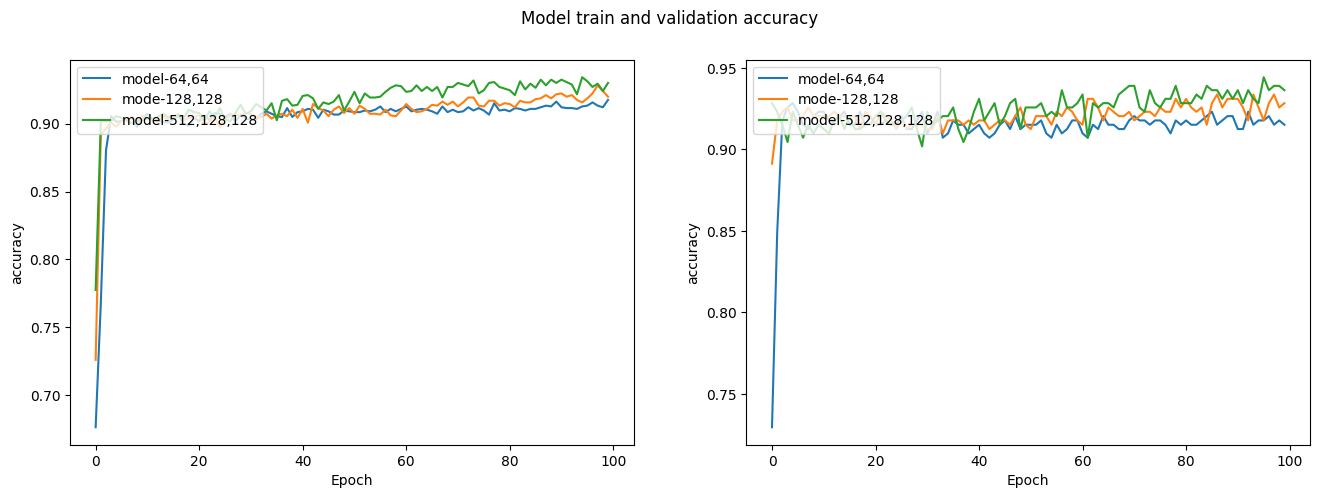

In [33]:
results = [history1, history2, history3]
labels = ['model-64,64', 'mode-128,128', 'model-512,128,128']
plot_evaluation('accuracy', results, labels)

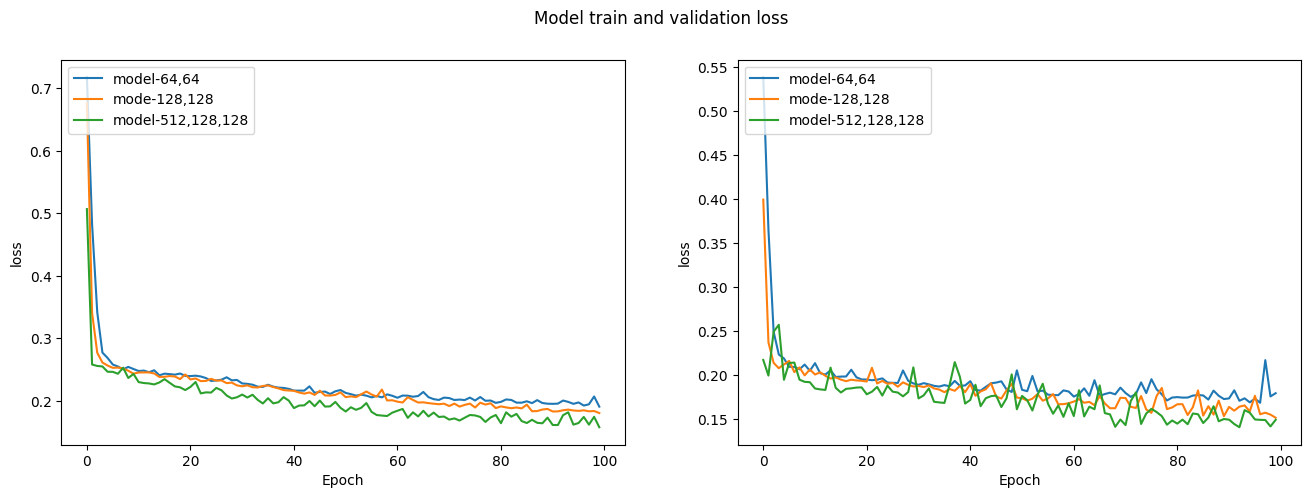

In [34]:
plot_evaluation('loss', results, labels)

We can conclude that the model with 3 layers of 512, 128 and 128 nodes in each layer is the best model. It has a loss of ~0.15 and accuracy of ~93%. We can also see that the model is not overfitting as the loss and accuracy of the validation set are very close to the ones of the training set. Now we will plot a confusion matrix to see how the model performs on each class.

12/12 [==============================] - 0s 2ms/step


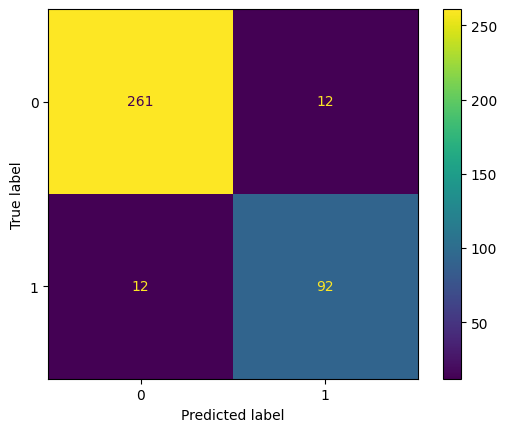

In [35]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

y_pred_merged_am = model3.predict(X_val_merged_am)
cm = confusion_matrix(y_val_merged_am, y_pred_merged_am.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [36]:
print(f"accuracy_score: {round(accuracy_score(y_val_merged_am, y_pred_merged_am.argmax(axis=1)), 3)}")
print(f"balanced_accuracy: {round(balanced_accuracy_score(y_val_merged_am, y_pred_merged_am.argmax(axis=1)), 3)}")
print(f"f1_score: {round(f1_score(y_val_merged_am, y_pred_merged_am.argmax(axis=1)), 3)}")
print(f"recall_score: {round(recall_score(y_val_merged_am, y_pred_merged_am.argmax(axis=1)), 3)}")
print(f"precision_score: {round(precision_score(y_val_merged_am, y_pred_merged_am.argmax(axis=1)), 3)}")

accuracy_score: 0.936
balanced_accuracy: 0.92
f1_score: 0.956
recall_score: 0.956
precision_score: 0.956


We can see that less than 4% of the data is misclassified. And the recall and precission of the model are very balanced.

#### Dropped amusement

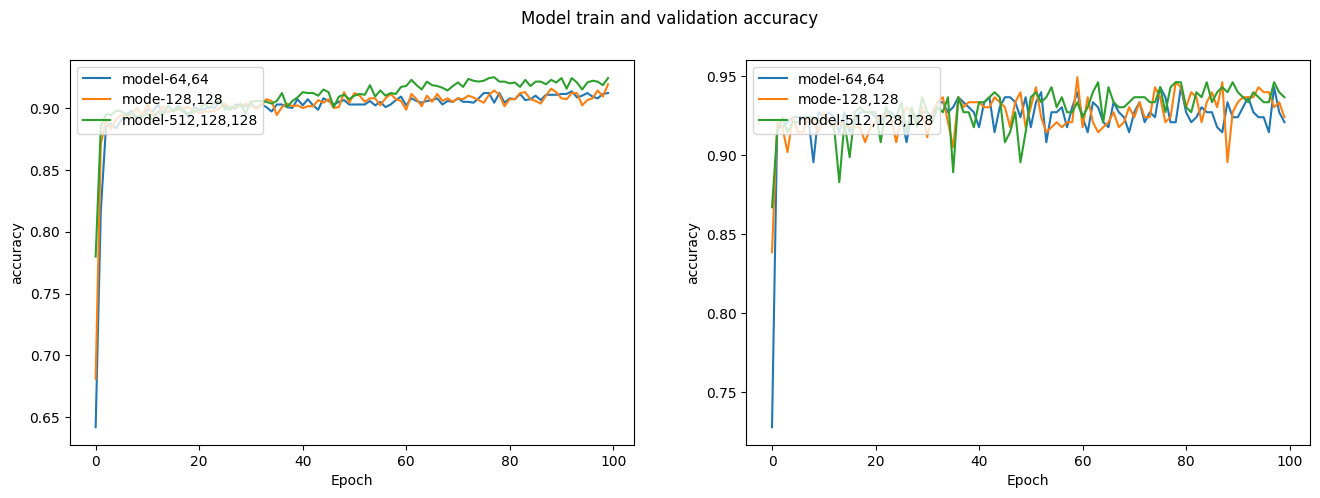

In [37]:
results_ = [history1_no_am, history2_no_am, history3_no_am]
labels_ = ['model-64,64', 'mode-128,128', 'model-512,128,128']
plot_evaluation('accuracy', results_, labels_)

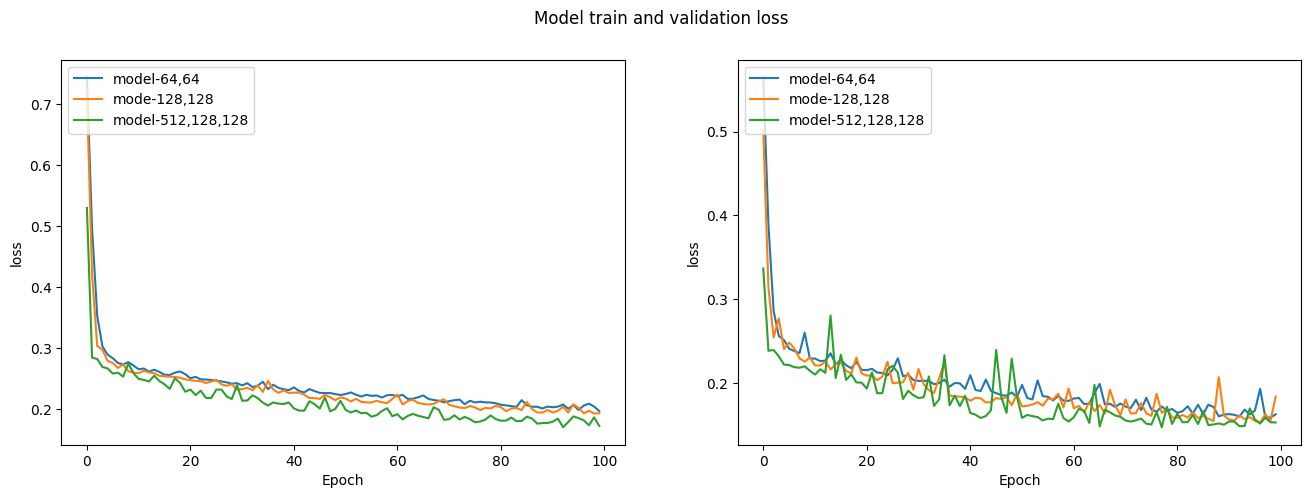

In [38]:
plot_evaluation('loss', results_, labels_)

We can conclude that the model with 3 layers of 512, 128 and 128 nodes in each layer is the best model. It has a loss of ~0.1 and accuracy of ~94%. We can also see that the model is not overfitting as the loss and accuracy of the validation set are very close to the ones of the training set. Now we will again plot a confusion matrix to see how the model performs on each class.

10/10 [==============================] - 0s 2ms/step


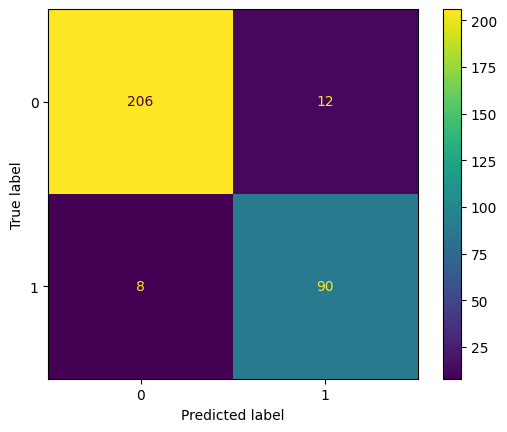

In [39]:
y_pred_no_am = model3_no_am.predict(X_val_no_am)
cm = confusion_matrix(y_val_no_am, y_pred_no_am.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [40]:
predictions = y_pred_no_am.argmax(axis=1)
print(f"accuracy_score: {round(accuracy_score(y_val_no_am, y_pred_no_am.argmax(axis=1)), 3)}")
print(f"balanced_accuracy: {round(balanced_accuracy_score(y_val_no_am, y_pred_no_am.argmax(axis=1)), 3)}")
print(f"f1_score: {round(f1_score(y_val_no_am, predictions), 3)}")
print(f"recall_score: {round(recall_score(y_val_no_am, predictions), 3)}")
print(f"precision_score: {round(precision_score(y_val_no_am, predictions), 3)}")

accuracy_score: 0.937
balanced_accuracy: 0.932
f1_score: 0.954
recall_score: 0.945
precision_score: 0.963


We can see that after predicting the validation data the accuracy is pretty low at 94% and again the recall and precission are pretty balanced with only 2% diviation.

### Explainability

In order to get a better understanding of how the model works we will use the SHAP library. SHAP is a game theoretic approach to explain the output of any machine learning model. SHAP values represent a feature's responsibility for a change in the model output. The sum of the SHAP values equals the difference between the expected model output and the model output when all features are set to their average value.

In [41]:
import shap

def prediction_wrapper(X):
    return model3.predict([X[:,i] for i in range(X.shape[1])]).flatten()

#### Merged amusement

First we will plot the SHAP values for the test set.

In [42]:
explainer = shap.KernelExplainer(
    model3.predict,
    X_test_merged_am
)

shap_values = explainer.shap_values(X_test_merged_am)

2/2 [==============================] - 0s 2ms/step


  0%|          | 0/42 [00:00<?, ?it/s]

40/40 [==============================] - 0s 1ms/step


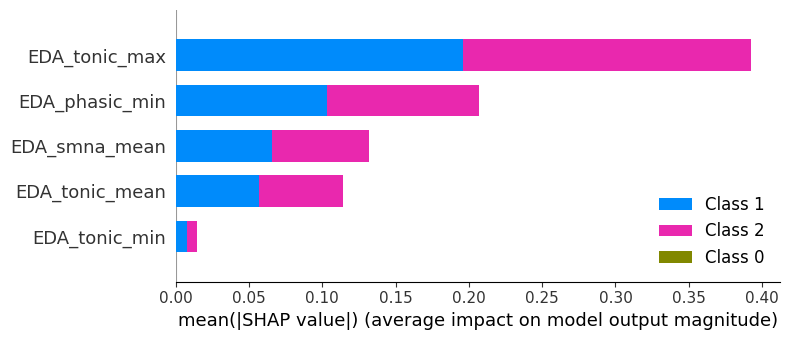

In [43]:
shap.summary_plot(shap_values=shap_values, features=X_test_merged_am, feature_names=features)

In [44]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_val_merged_am[1])

Now we will use the Interpret ML library to visualize the SHAP values for the first 10 samples of the test set.

In [45]:
from interpret import show
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
#set_visualize_provider(InlineProvider())
from interpret.blackbox import ShapKernel
from interpret.blackbox import LimeTabular
from interpret.blackbox import MorrisSensitivity
from interpret.blackbox import PartialDependence

In [46]:
shap = ShapKernel(predict_fn=model3.predict, data=X_train_merged_am, feature_names=features)
shap_local = shap.explain_local(X_test_merged_am[:10], y_test_merged_am[:10])

show(shap_local)

53/53 [==============================] - 0s 1ms/step


Using 1672 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


<!-- http://127.0.0.1:7001/1915800006720/ -->

Morris Sensitivity Analysis is a method for computing the sensitivity of a model's outputs to the inputs. It is a global sensitivity analysis method, which means that it can be used to analyze the sensitivity of the model's outputs to the inputs without having to train the model multiple times. The method is based on the idea that the model's outputs can be approximated by a linear function of the inputs. The method is based on the idea that the model's outputs can be approximated by a linear function of the inputs.

In [47]:
msa = MorrisSensitivity(predict_fn=model3.predict, data=X_train_merged_am, feature_names=features)
msa_global = msa.explain_global()
show(msa_global)

188/188 [==============================] - 0s 2ms/step


<!-- http://127.0.0.1:7001/1917485041408/ -->

Finally we will use the LIME method to explain the model. LIME is a model-agnostic method for explaining the predictions of any machine learning classifier. It is based on the idea that if we could approximate the classifier locally with a linear model, we could easily interpret the weights of the local linear model.

In [48]:
lime = LimeTabular(predict_fn=model3.predict, data=X_train_merged_am, feature_names=features)
lime_local = lime.explain_local(X_test_merged_am[:5], y_test_merged_am[:5])

show(lime_local)

157/157 [==============================] - 0s 2ms/step


<!-- http://127.0.0.1:7001/1915882656896/ -->

Partially Dependent Plot
  
Partially dependent plots show the relationship between the model output and a single feature, marginalizing over all the other features. This is useful for understanding the effect of a single feature on the model output.

In [49]:
#pdp = PartialDependence(predict_fn=model3.predict, data=X_train_merged_am, feature_names=features)
#pdp_global = pdp.explain_global()

#show(pdp_global)

#### Dropped amusement
We will use the same XAI methods as we used for the merged data.

In [50]:
import shap
explainer_no_am = shap.KernelExplainer(
    model3_no_am.predict,
    X_test_no_am
)

shap_values_no_am = explainer_no_am.shap_values(X_test_no_am)

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/36 [00:00<?, ?it/s]

34/34 [==============================] - 0s 1ms/step


SHAP values

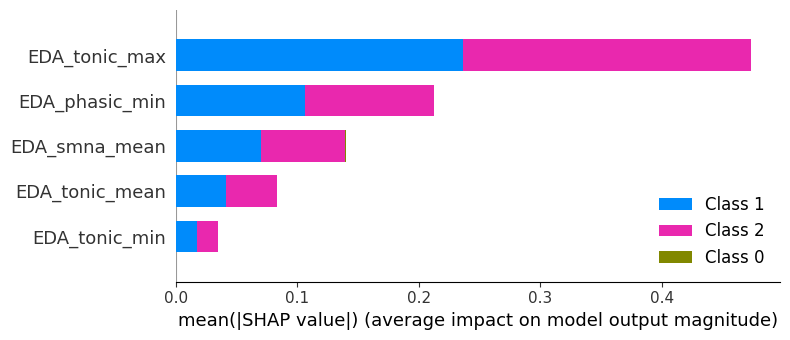

In [51]:
shap.summary_plot(shap_values=shap_values_no_am, features=X_test_no_am, feature_names=features)

In [52]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_no_am[1], X_val_no_am[1])

In [53]:
shap_no_am = ShapKernel(predict_fn=model3_no_am.predict, data=X_train_no_am, feature_names=features)
shap_local_no_am = shap_no_am.explain_local(X_test_no_am[:10], y_test_no_am[:10])

show(shap_local_no_am)

44/44 [==============================] - 0s 2ms/step


Using 1408 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<!-- http://127.0.0.1:7001/1915876569488/ -->

Morris Sensitivity Analysis

In [54]:
msa = MorrisSensitivity(predict_fn=model3_no_am.predict, data=X_train_no_am, feature_names=features)
msa_global_no_am = msa.explain_global()
show(msa_global_no_am)

188/188 [==============================] - 0s 1ms/step


<!-- http://127.0.0.1:7001/1915875604320/ -->

LIME

In [55]:
lime_no_am = LimeTabular(predict_fn=model3_no_am.predict, data=X_train_no_am, feature_names=features)
lime_local_no_am = lime_no_am.explain_local(X_test_no_am[:5], y_test_no_am[:5])

show(lime_local_no_am)

157/157 [==============================] - 0s 1ms/step


<!-- http://127.0.0.1:7001/1915876765808/ -->

Partially Dependent Plot

In [56]:
#pdp_no_am = PartialDependence(predict_fn=model3_no_am.predict, data=X_train_no_am, feature_names=features)
#pdp_global_no_am = pdp_no_am.explain_global()

#show(pdp_global_no_am)